In [2]:
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
from tensorboardX import SummaryWriter
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import numpy as np
from PIL import Image
import json
import os
from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data_dir = "car_dam/data2a/"

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                      transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(data_dir + '/training', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=128)

In [3]:
model = models.resnet152(pretrained=True)
fc_in_size = model.fc.in_features
model.fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(fc_in_size, 1024)),
                                      ('dropout2', nn.Dropout(0.5)),
                                      ('relu2', nn.ReLU()),
                                      ('fc2', nn.Linear(1024, 3)),
                                      ('output', nn.LogSoftmax(dim=1))]))

In [4]:
for n, p in model.named_parameters():
    if n.split('.')[0] == 'fc':
        pass
    else:
        p.requires_grad = False

count = 0
for p in model.parameters():
    if p.requires_grad:
        print(p.size())
        count += 1
print(count)

torch.Size([1024, 2048])
torch.Size([1024])
torch.Size([3, 1024])
torch.Size([3])
4


In [5]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        output = model.forward(images.cuda())
        labels = labels.type(torch.LongTensor).cuda()
        test_loss += criterion(output, labels).item()
    
    return test_loss

In [4]:
checkpoint_run = True
inf = torch.load('Models/3_Classify/resnet152_epoch34_step280.pkl')
model.load_state_dict(inf['model_state_dict'])

In [8]:
SAVE_PATH = "Models/3_Classify/"

# writer = SummaryWriter()
model = model.cuda()
criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)
if checkpoint_run:
    optimizer.load_state_dict(inf['optimizer_state_dict'])

best_train_loss = 0.7
best_val_loss = 0.7

# scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15, 25, 40, 50], gamma=0.1)

num_epochs = 100
running_loss = 0
steps = 0
print_every = 10
log_every = 10
log_step = 0


log_every = 10
for epoch in range(num_epochs):
    model.train()
#     scheduler.step()
    for data_ in trainloader:
        steps += 1
        img, bbox = data_
        
        img = img.cuda()
        target = bbox.type(torch.LongTensor).cuda()
        
        output = model(img)
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % log_every == 0:
            log_step += 1
            model.eval()

            with torch.no_grad():
                valid_loss = validation(model, testloader, criterion)
            model.train()
            
            train_loss = running_loss/log_every
            val_loss = valid_loss/len(testloader)
            
#             writer.add_scalar('Training Loss', train_loss, log_step)
#             writer.add_scalar('Validation Loss', val_loss, log_step)
#             writer.add_scalar('Learning rate', optimizer.state_dict()['param_groups'][0]['lr'], log_step)
            
            if val_loss < best_val_loss and train_loss < best_train_loss:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss
            }, SAVE_PATH + "resnet152_3_epoch{}_step{}.pkl".format(epoch, steps))
                best_train_loss = train_loss
                best_val_loss = val_loss
            running_loss = 0
            
        if steps % print_every == 0:
            print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
                  "Training Loss: {:.4f}.. ".format(train_loss),
                  "valid Loss: {:.4f}.. ".format(val_loss))
# writer.close()

Epoch: 2/100..  Training Loss: 0.7381..  valid Loss: 0.7688.. 
Epoch: 3/100..  Training Loss: 0.7253..  valid Loss: 0.8072.. 
Epoch: 4/100..  Training Loss: 0.7495..  valid Loss: 0.7495.. 
Epoch: 5/100..  Training Loss: 0.7240..  valid Loss: 0.8005.. 
Epoch: 7/100..  Training Loss: 0.7416..  valid Loss: 0.7601.. 
Epoch: 8/100..  Training Loss: 0.7310..  valid Loss: 0.7608.. 
Epoch: 9/100..  Training Loss: 0.6997..  valid Loss: 0.7839.. 
Epoch: 10/100..  Training Loss: 0.7282..  valid Loss: 0.7591.. 
Epoch: 12/100..  Training Loss: 0.7467..  valid Loss: 0.7674.. 
Epoch: 13/100..  Training Loss: 0.7095..  valid Loss: 0.7966.. 
Epoch: 14/100..  Training Loss: 0.7383..  valid Loss: 0.7748.. 
Epoch: 15/100..  Training Loss: 0.7258..  valid Loss: 0.7682.. 
Epoch: 17/100..  Training Loss: 0.6895..  valid Loss: 0.7810.. 
Epoch: 18/100..  Training Loss: 0.7366..  valid Loss: 0.7688.. 
Epoch: 19/100..  Training Loss: 0.7121..  valid Loss: 0.7800.. 
Epoch: 20/100..  Training Loss: 0.7169..  valid

In [7]:
model = model.cuda()
model.eval()

y_pred = list()
y_true = list()

with torch.no_grad():
    for imgs, op in iter(testloader):
        k = model.forward(imgs.cuda())
        y_pred.extend(list(np.argmax(k.cpu().data.numpy(), axis=1)))
        y_true.extend(op.cpu().data.numpy())

## Confusion Matrix

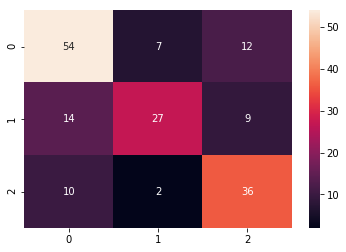

In [10]:
conf_matrix = confusion_matrix(y_pred=y_pred, y_true=y_true)
_ = sns.heatmap(conf_matrix, annot=True)

In [11]:
print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.69      0.74      0.72        73
           1       0.75      0.54      0.63        50
           2       0.63      0.75      0.69        48

   micro avg       0.68      0.68      0.68       171
   macro avg       0.69      0.68      0.68       171
weighted avg       0.69      0.68      0.68       171

